In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
import dask
from dask import delayed
from dask.diagnostics import ProgressBar
from dask.multiprocessing import get
from sklearn.preprocessing import normalize

from scipy.spatial.distance import cosine, mahalanobis
from sklearn.metrics import roc_curve, precision_score
from scipy.sparse import csr_matrix
from scipy.stats import entropy

VEC_DIM = 400

FILE_DIR = "/work4/tzy/spk_verify_backend/exp_dvectors/" #folder where all files are located
!ls /work4/tzy/spk_verify_backend/exp_dvectors

enroll.ark  enroll.spk2utt  test.ark  test.spk2utt  trials


In [3]:
def run_test(score_func, sample_size = 0.10, ESPK = 0, TSPK = 0, n_features = 1, dask_array = False, pairs=None):

    def score_vectors(x):
        """
        enroll_id: ID of enrolled speaker 
        test_id: ID of a test speaker
        enroll_spk: Dataframe of enroll speakers and processed utterance vectors 
        test_spk: As enroll_spk
        score_func: scoring function that takes 2 speakers' data and produces a score
        """
        enroll_data = ESPK.loc[x['enroll']] # Pandas series
        test_data = TSPK.loc[x['test_id']]
        res = score_func(enroll_data, test_data)
        return res

    dask_pairs = dd.from_pandas(pairs, npartitions=16).sample(frac= sample_size, random_state=1)
    #dask_pairs = dd.from_pandas(pairs, npartitions=16)
    meta = ('x','f8')

    scores = 0
    
    pbar = ProgressBar()
    pbar.register()
    scores = dask_pairs.map_partitions(lambda df: df.apply(score_vectors ,axis=1), meta=meta)
    
    #New impl returns data in stacked format and takes 1/3 time
    if n_features>1: # This conditional halves the time if n_features==1
        scores = dask.array.from_delayed(delayed(np.vstack)(scores.values), shape=(len(dask_pairs), n_features), dtype='float64')
        scores = scores.rechunk((1000,500))
    res =  dask.array.from_array(np.array(dask_pairs['result']), (1000,))
    #res.rechunk((1000,500))
    if dask_array:
        pbar.unregister()
        return scores, res
    
    #scores = scores if delayed_res else scores.compute() #Turns out it is faster to do dd.compute(*(scores.compute())) if the inner func produces delayed objs
    scores = scores.compute(get=get)
    res = res.compute()
    pbar.unregister()
    
    return scores, res

def calcEER(series, true, name = ""):
    fpr, tpr, thresholds = roc_curve(true, series)
    plt.plot(fpr, tpr)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    fnr = 1 - tpr
    minPt = np.nanargmin(np.absolute((fnr - fpr)))
    print("Threshold: ", thresholds[minPt])
    print("EER/FPR: ", fpr[minPt])
    print("FNR: ", fnr[minPt])
    
    if name:
        plt.savefig(name)
    
    return

def read_trials(filename):
    pairs = pd.read_table(FILE_DIR+filename, names = ["enroll","test_id","result"], sep = " ") 
    print("num of trials: ",len(pairs))

    # Encode "nontarget" as 0, "target as 1"
    pairs['result'].replace({"nontarget":0, "target":1}, inplace = True)
    print(pairs.head())
    return pairs

def read_spk2utt_utts(filename):  
    """Processes the utterance vectors for each speaker
        filename: name of spk2utt file
        ark_df: corresponding ark file"""
    df = pd.read_table(FILE_DIR+filename, names = ['id', 'utt1', 'utt2','utt3','utt4','utt5'], sep = " ") 
    df.dropna(axis=1, inplace=True)
    df.index = df['id']
    df = df.drop('id', 1)
    return df 

def cos_similarity(vect1, vect2):
    return 1 - cosine(vect1, vect2)

# Calculate FPR and FNR with variable thresholds for scores
# Takes predictions and results 
def calcFR(pred, true):
    fpr = pred[(pred==1) & (true==0)].sum()/(true==0).sum()
    fnr = true[(pred==0) & (true==1)].sum()/(true==1).sum()
    print("FPR: ", fpr)
    print("FNR: ", fnr)
    
def sendScores(scores, res, name):
    pd.DataFrame(data=np.vstack((scores, res))).to_hdf("scores.h5", name)
    
def showH5(filename):
    with pd.HDFStore(filename) as store:
        print(store.keys())

In [4]:
# Load spk data from h5
# enroll_spk = pd.read_hdf('spk.h5', 'enroll')
# test_spk = pd.read_hdf('spk.h5', 'test')
enroll_spk_raw = pd.read_hdf('spk_raw.h5', 'enroll_raw')
test_spk_raw = pd.read_hdf('spk_raw.h5', 'test_raw')

# enroll_ark_samp_tenth = pd.read_hdf('samp.h5', 'enroll_ark_samp_tenth')
# test_ark_samp_tenth = pd.read_hdf('samp.h5', 'test_ark_samp_tenth')

# enroll_utts = read_spk2utt_utts("enroll.spk2utt")
# test_utts = read_spk2utt_utts("test.spk2utt")

# pairs_samp = pd.read_hdf('samp.h5', 'pairs_samp_100k')

In [41]:
%%timeit
manhattan_dist(enroll_spk_raw.loc[4780176039], test_spk_raw.loc['fc_4779876202_1'])

772 µs ± 507 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [10]:
from scipy.spatial.distance import cdist

def manhattan_dist(dist1, dist2):
    print(cdist(dist1, dist2, 'cityblock'))
    return np.mean(cdist(dist1, dist2, 'cityblock'))

def manhattan_dist_frame_delayed(spkr_utts, test_utts):
    res = []
    for s in spkr_utts:
        for t in test_utts:
            spkr =  enroll_ark_samp_tenth.loc[s]
            test = test_ark_samp_tenth.loc[t]
            res.append(delayed(manhattan_dist)(spkr, test))
    return delayed(np.mean)(res)

def manhattan_dist_frame(spkr_utts, test_utts):
    res = []
    for s in spkr_utts:
        for t in test_utts:
            spkr = enroll_ark_samp_tenth.loc[s]
            test = test_ark_samp_tenth.loc[t]
            res.append(manhattan_dist(spkr, test))
    return np.mean(res)

In [122]:
%%time
e = pairs_samp['enroll'].values
t = pairs_samp['test_id'].values
m_scores = []
for i in range(100000):
    m_scores.append(delayed(manhattan_dist_frame_delayed)(enroll_utts.loc[e[i]], test_utts.loc[t[i]]))

CPU times: user 23.1 s, sys: 1.25 s, total: 24.4 s
Wall time: 24.2 s


In [ ]:
p  = ProgressBar()
p.register()
mdist_frame = dd.compute(*m_scores)
p.unregister()

[                                        ] | 1% Completed | 19min  1.0s

In [ ]:
mdist_frame, res = run_test(manhattan_dist_frame, 0.01, enroll_utts, test_utts, pairs=pairs_samp)

[########################################] | 100% Completed |  0.7s
[                                        ] | 0% Completed | 14min 13.0s

In [111]:
%%time
mdist_frame = manhattan_dist_frame_delayed(enroll_utts.loc[4780176039], test_utts.loc['fc_4779876202_1'])

CPU times: user 26.5 ms, sys: 1.87 ms, total: 28.3 ms
Wall time: 28 ms


In [112]:
%%time
mdist_frame = dd.compute(mdist_frame)

[########################################] | 100% Completed |  0.1s
CPU times: user 72.7 ms, sys: 5.61 ms, total: 78.3 ms
Wall time: 106 ms


In [110]:
%%time
mdist_frame = manhattan_dist_frame(enroll_utts.loc[4780176039], test_utts.loc['fc_4779876202_1'])

CPU times: user 79.5 ms, sys: 1.7 ms, total: 81.2 ms
Wall time: 80.8 ms


# Manhattan on spkr level data? - much faster and generally same performance

In [7]:
pairs = read_trials('trials')

num of trials:  11725308
       enroll          test_id  result
0  4780420411  fc_4779547143_0       0
1  4780420411  fc_4779547143_1       0
2  4780420411  fc_4779547143_2       0
3  4780420411  fc_4779547143_3       0
4  4780420411  fc_4779547143_4       0


In [11]:
manhattan_dist(enroll_spk_raw.loc[4780420411], test_spk_raw.loc['fc_4779547143_0'])

[[7.83984235 7.97218719 7.92279195]
 [9.11571291 9.24792605 9.05652069]
 [8.18590414 8.30821712 8.3403082 ]
 [7.88416314 7.99446204 7.93492518]
 [8.11241367 8.29691198 8.17754014]]


8.292655117281006

In [21]:
mdist, res = run_test(manhattan_dist, 0.1, enroll_spk_raw, test_spk_raw, pairs=pairs)

[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  3min 56.6s
[########################################] | 100% Completed |  0.4s


In [6]:
showH5('scores.h5')

['/cos_10', '/cos_50', '/cos_samp_100k', '/kl_frame_100k', '/kl_spkr_10', '/kl_spkr_50', '/manhattan_spk_samp_100k', '/manhattan_spkr_10', '/var_10', '/var_50', '/var_samp_100k', '/zscore_10', '/zscore_50', '/zscore_samp_100k']


In [8]:
mdist, res = run_test(manhattan_dist, 0.5, enroll_spk_raw, test_spk_raw, pairs=pairs)
sendScores(mdist, res, 'manhattan_50')

[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed | 17min 31.1s
[########################################] | 100% Completed |  1.5s


Threshold:  8.34973159476754
EER/FPR:  0.8036191249012364
FNR:  0.8036605657237936


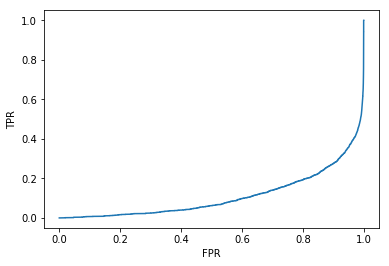

In [22]:
calcEER(mdist, res) #max - is shit

Threshold:  7.466514835762768
EER/FPR:  0.8926861560144355
FNR:  0.8929561841375485


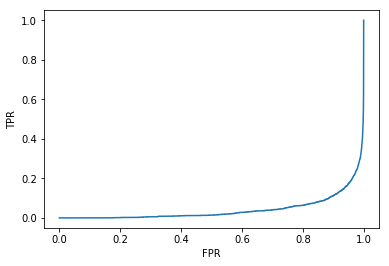

In [19]:
calcEER(mdist, res) #mean og